In [430]:
from bson import ObjectId
import pymongo
import statistics
import time

host="192.168.50.41"
port=27017
db_name='mt'
client = pymongo.MongoClient(host, port)
db = client[db_name]
datColl = db['drift_dat']

testRecID = ObjectId("66dcc7712a8feda69b1446fb")

for test_rec in datColl.find({"_id": testRecID}):
    
    vals_ts_sec = test_rec['ts']
    vals_sense_bits = test_rec['vals_sense']
    vals_t1_bits = test_rec['vals_t1']
    vals_t2_bits = test_rec['vals_t2']
    
# Convert ADC values to appropriate units
# Starting with getting the sensor output into distance (mm)
adc_bits = 14
adc_refV = 5
adc_res = adc_refV / (2**adc_bits) # adc resolution in volts/bit
sensor_sensitivity = 4.62 # sensitivity in V/mm
meas_res = adc_res / sensor_sensitivity # measurement sensitivity in mm/bit

vals_sense = []
for val in vals_sense_bits:
    vals_sense.append((val - vals_sense_bits[0]) * meas_res)

V_s = 5
R4 = 22000

#therm_sens = 5 / 100 #approx thermistor driver output sensitivity in V/degC
#therm_res = adc_res / therm_sens
vals_t1 = []
for val in vals_t1_bits:
    V_res = val * adc_res
    res = R4 * ((1-V_res/V_s)/(1+V_res/V_s))
    temp = -0.00155 * res + 39.9
    vals_t1.append(temp)

vals_t2 = []
for val in vals_t2_bits:
    V_res = val * adc_res
    res = R4 * ((1-V_res/V_s)/(1+V_res/V_s))
    temp = -0.00155 * res + 39.9
    vals_t2.append(temp)

vals_ts = []
for val in vals_ts_sec:
    vals_ts.append((val - vals_ts_sec[0]) / 3600)


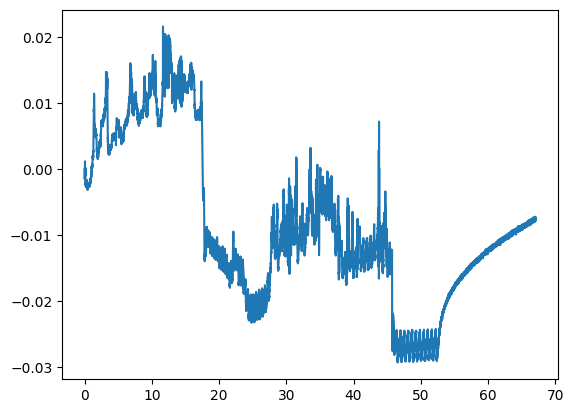

In [431]:
from matplotlib import pyplot as plt

plt.plot(vals_ts, vals_sense)

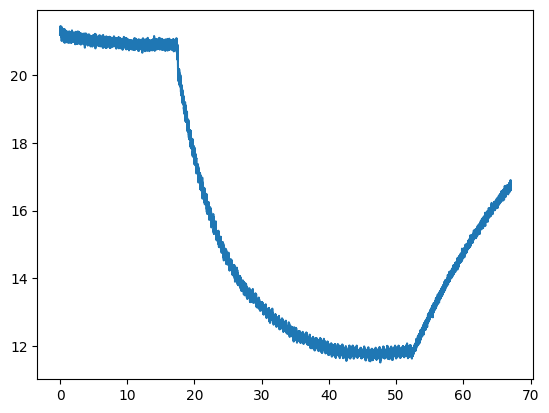

In [432]:
plt.plot(vals_ts, vals_t1)

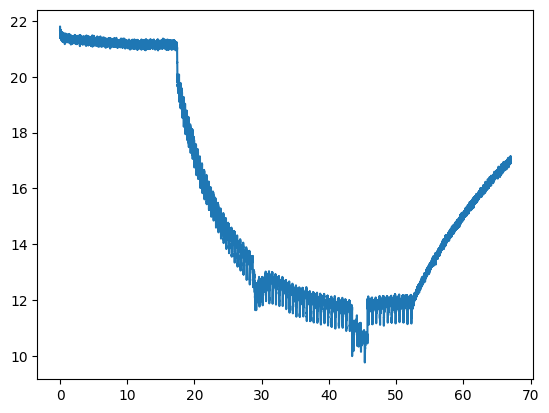

In [433]:
plt.plot(vals_ts, vals_t2)

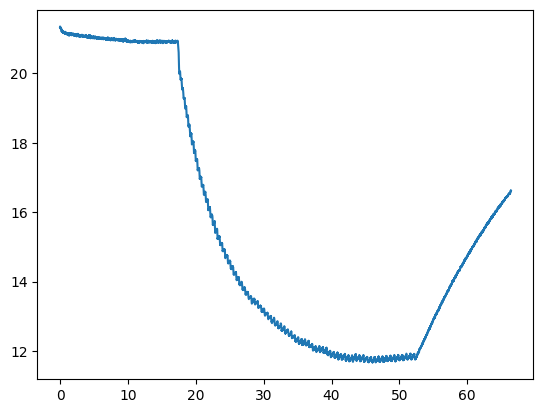

In [421]:
# Adding a boxcar filter to the temp measurements
vals_t1_smooth = []
smooth_weight = 20
for inc, val in enumerate(vals_t1[:-smooth_weight]):
    i = 0
    subset = 0
    while i < smooth_weight:
        subset = subset + vals_t1[inc + i]
        i += 1
    vals_t1_smooth.append(subset/smooth_weight)

plt.plot(vals_ts[:-smooth_weight], vals_t1_smooth)

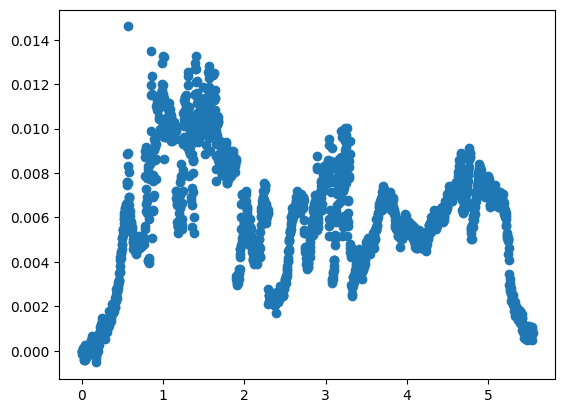

In [275]:
# Stability dataset
vals_ts_stable = []
vals_sense_stable = []
vals_t1_stable = []
vals_t2_stable = []
for val in vals_ts[4000:6000]:
    vals_ts_stable.append(val - vals_ts[4000])
for val in vals_sense[4000:6000]:
    vals_sense_stable.append(val - vals_sense[4000])
for val in vals_t1[4000:6000]:
    vals_t1_stable.append(val - vals_t1[4000])
for val in vals_t2[4000:6000]:
    vals_t2_stable.append(val - vals_t2[4000])

plt.scatter(vals_ts_stable, vals_sense_stable)

In [276]:
print(min(vals_sense_stable))
print(max(vals_sense_stable))

-0.000528442911255411
0.014598235423430736


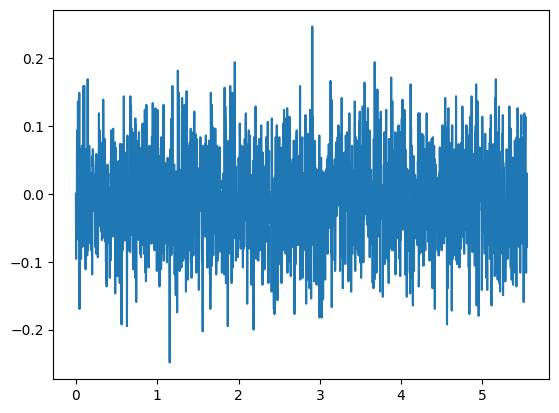

In [72]:
plt.plot(vals_ts_stable, vals_t1_stable)

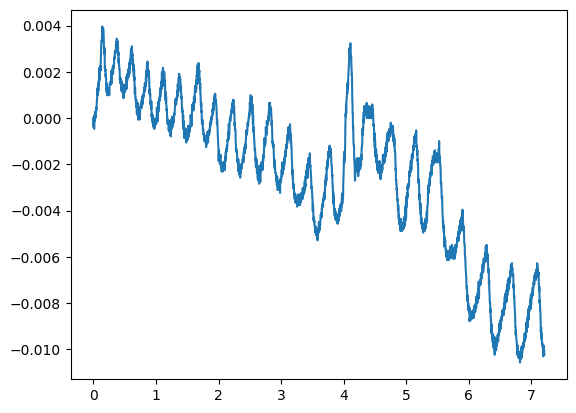

In [242]:
# Temp change zone 1
# Start zone 1 at point 6300
vals_ts_z1 = []
vals_sense_z1 = []
vals_t1_z1 = []
vals_t2_z1 = []
i_start = 6500
i_stop = 9104
for val in vals_ts[i_start:i_stop]:
    vals_ts_z1.append(val - vals_ts[i_start])
for val in vals_sense[i_start:i_stop]:
    vals_sense_z1.append(val - vals_sense[i_start])
for val in vals_t1[i_start:i_stop]:
    vals_t1_z1.append(val - vals_t1[i_start])
for val in vals_t2[i_start:i_stop]:
    vals_t2_z1.append(val - vals_t2[i_start])

plt.plot(vals_ts_z1, vals_sense_z1)

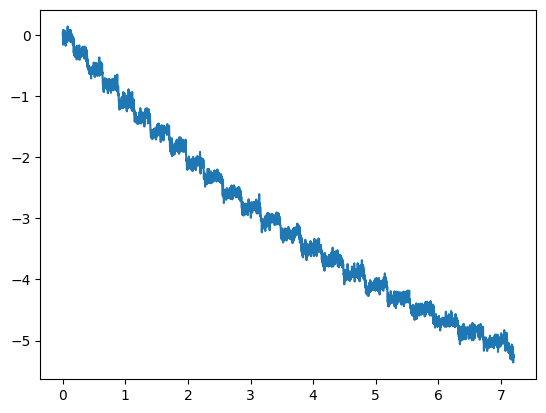

In [243]:
plt.plot(vals_ts_z1, vals_t1_z1)
#plt.plot(vals_ts_z1, vals_sense_z1, secondary_y=True)

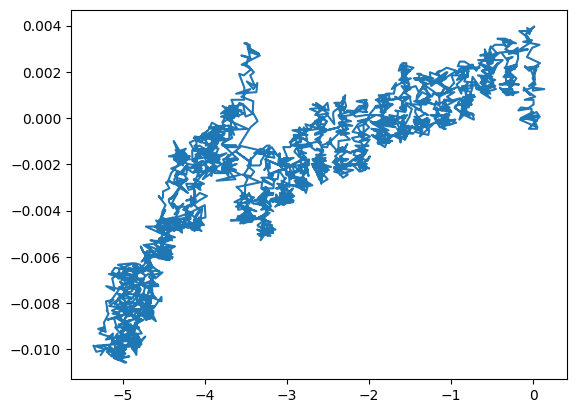

In [244]:
plt.plot(vals_t1_z1, vals_sense_z1)

In [245]:
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression()
sub_t1 = np.array(vals_t1_z1)
sub_t2 = np.array(vals_t2_z1)
sub_sense = np.array(vals_sense_z1)
reg.fit(sub_t1.reshape((-1,1)), sub_sense)
print(f'Slope: {round(reg.coef_[0], 4)} mm/degC')

Slope: 0.0019 mm/degC


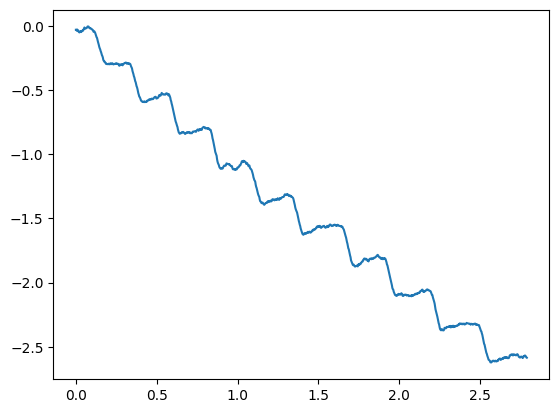

In [188]:
vals_t1_z1_smooth = []
smooth_weight = 20
for inc, val in enumerate(vals_t1_z1[:-smooth_weight]):
    i = 0
    subset = 0
    while i < smooth_weight:
        subset = subset + vals_t1_z1[inc + i]
        i += 1
    vals_t1_z1_smooth.append(subset/smooth_weight)

plt.plot(vals_ts_z1[:-smooth_weight], vals_t1_z1_smooth)

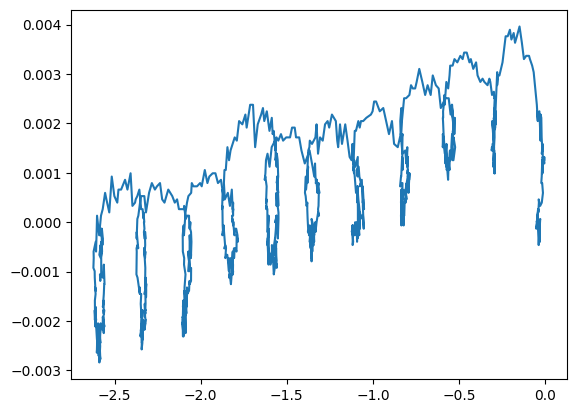

In [190]:
plt.plot(vals_t1_z1_smooth, vals_sense_z1[:-smooth_weight])

In [365]:
print(len(vals_t1))

18907


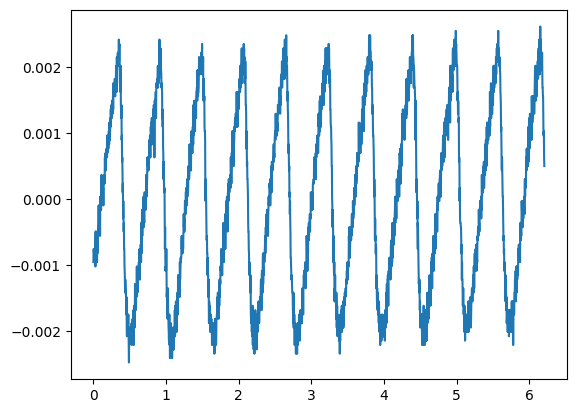

In [380]:
# At 1323 on 9/9/2024, electronics moved to inside of cooler. Data point at this time: 16545
# However, there is a bit of a transient from 16545 to 16650, so 16650 is start of dataset for full system under temp control.
sys_start = 16650
sys_stop = 18907
vals_ts_sys = []
vals_sense_sys = []
for val in vals_ts[sys_start:sys_stop]:
    vals_ts_sys.append(val - vals_ts[sys_start])
for val in vals_sense[sys_start:sys_stop]:
    vals_sense_sys.append(val - statistics.mean(vals_sense[sys_start:sys_stop]))
plt.plot(vals_ts_sys, vals_sense_sys)




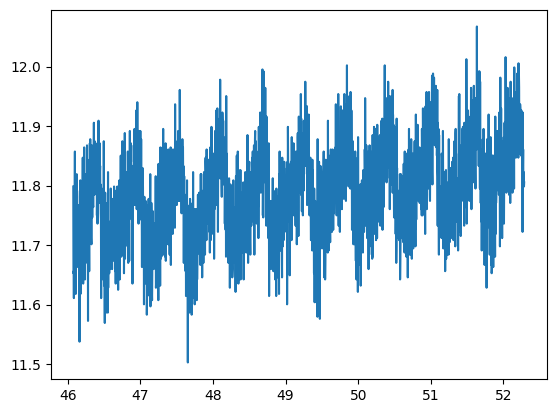

In [367]:
plt.plot(vals_ts[sys_start:sys_stop], vals_t1[sys_start:sys_stop])

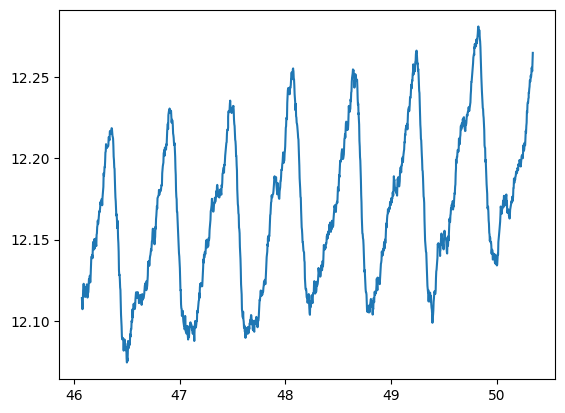

In [359]:
vals_t1_sys_smooth = []
smooth_weight = 30
for inc, val in enumerate(vals_t1[sys_start:-smooth_weight]):
    i = 0
    subset = 0
    while i <= smooth_weight:
        subset = subset + vals_t1[sys_start + inc + i]
        i += 1
    vals_t1_sys_smooth.append(subset/smooth_weight)

plt.plot(vals_ts[sys_start:-smooth_weight], vals_t1_sys_smooth)

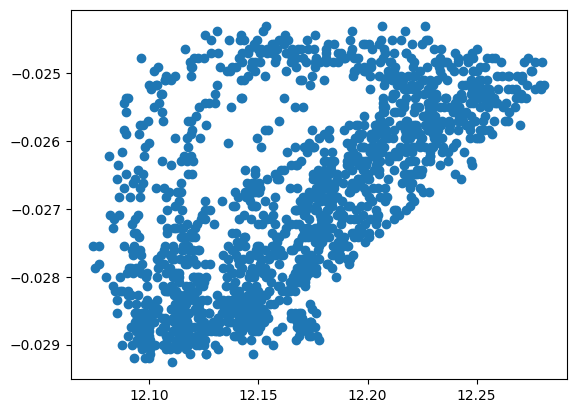

In [360]:
plt.scatter(vals_t1_sys_smooth, vals_sense[sys_start:-smooth_weight])

In [337]:
print(len(vals_t1_sys_smooth))

0


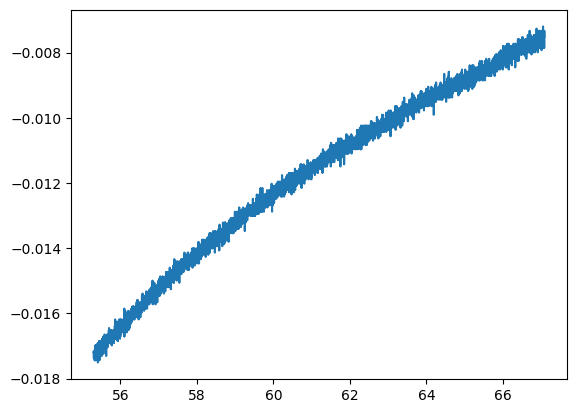

In [434]:
# At 2015, cooler turned off to allow return to 'ambient' temp
temp_start = 20000
temp_stop = len(vals_ts)
vals_ts_temp = vals_ts[temp_start:temp_stop]
vals_sense_temp = vals_sense[temp_start:temp_stop]
vals_t1_temp = vals_t1[temp_start:temp_stop]
vals_t2_temp = vals_t2[temp_start:temp_stop]
plt.plot(vals_ts_temp,vals_sense_temp)


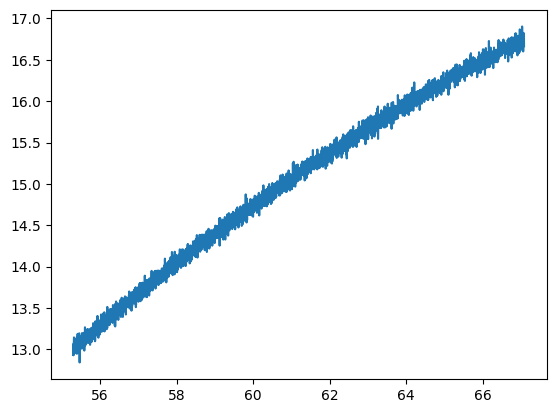

In [435]:
plt.plot(vals_ts[temp_start:], vals_t1[temp_start:])

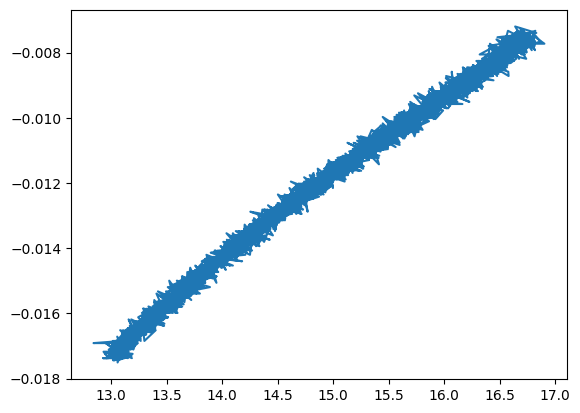

In [436]:
plt.plot(vals_t1[temp_start:], vals_sense[temp_start:])

In [437]:
reg = linear_model.LinearRegression()
sub_t1 = np.array(vals_t1_temp)
sub_t2 = np.array(vals_t2_temp)
sub_sense = np.array(vals_sense_temp)
reg.fit(sub_t1.reshape((-1,1)), sub_sense)
print(f'Slope: {round(reg.coef_[0], 4)} mm/degC')

Slope: 0.0025 mm/degC
